# Disaster Tweets Classifier

In [1]:
# installing all dependencies required for the notebook
%pip install -r requirements.txt

You should consider upgrading via the '/Users/weiting/Code/disaster-tweets-classifier/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Data Exploration & Pre-processing

## Data exploration

### Looking at data
Let's check out the form of the data, the column names, shapes and missing data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/train.csv', index_col='id')
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
df.shape # 7613 rows, with 4 columns

(7613, 4)

In [10]:
# target 1 refers to disaster tweet, 0 is not a disaster tweet
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
# checking for completeness of data
print(f"{np.sum(df['keyword'].isna())} rows have no keywords")
print(f"{np.sum(df['location'].isna())} rows have no location")
print(f"{np.sum(df['text'].isna())} rows have no text")
print(f"{np.sum(df['text'].isna())} rows have no target")

61 rows have no keywords
2533 rows have no location
0 rows have no text
0 rows have no target


### Data visualization
Let's look at some statistics from our data

Text(0.5, 1.0, 'Character distribution')

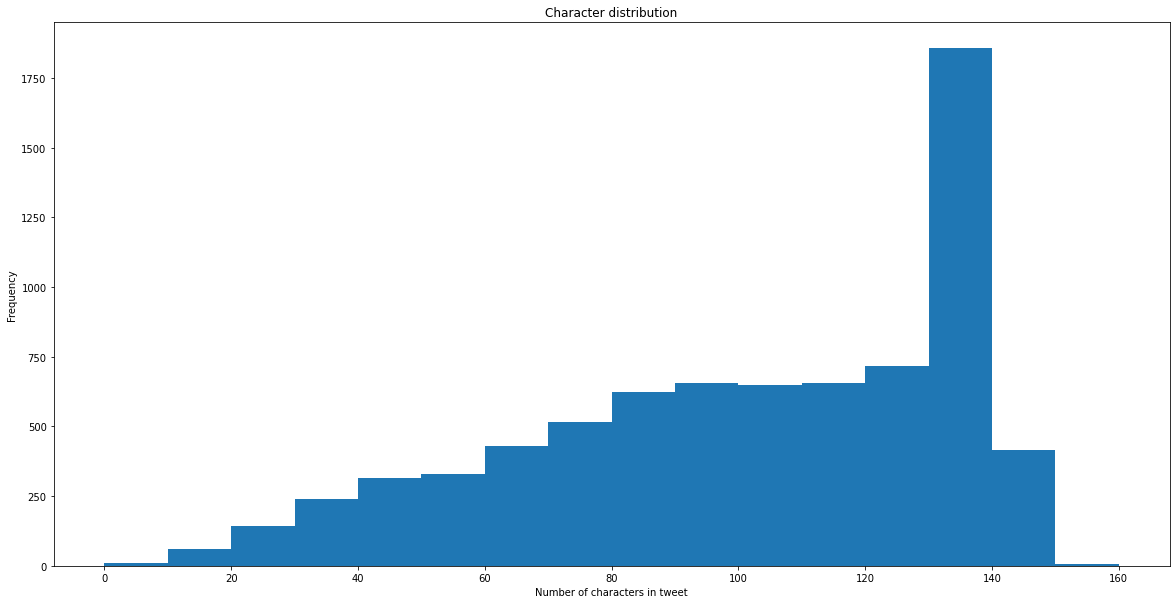

In [71]:
# Number of characters per tweet
plt.figure(figsize=(20,10))
df['text'].str.len().hist(grid=False,bins=range(0,170,10))
plt.xlabel('Number of characters in tweet')
plt.ylabel('Frequency')
plt.title('Character distribution')

Text(0.5, 1.0, 'Number of words distribution')

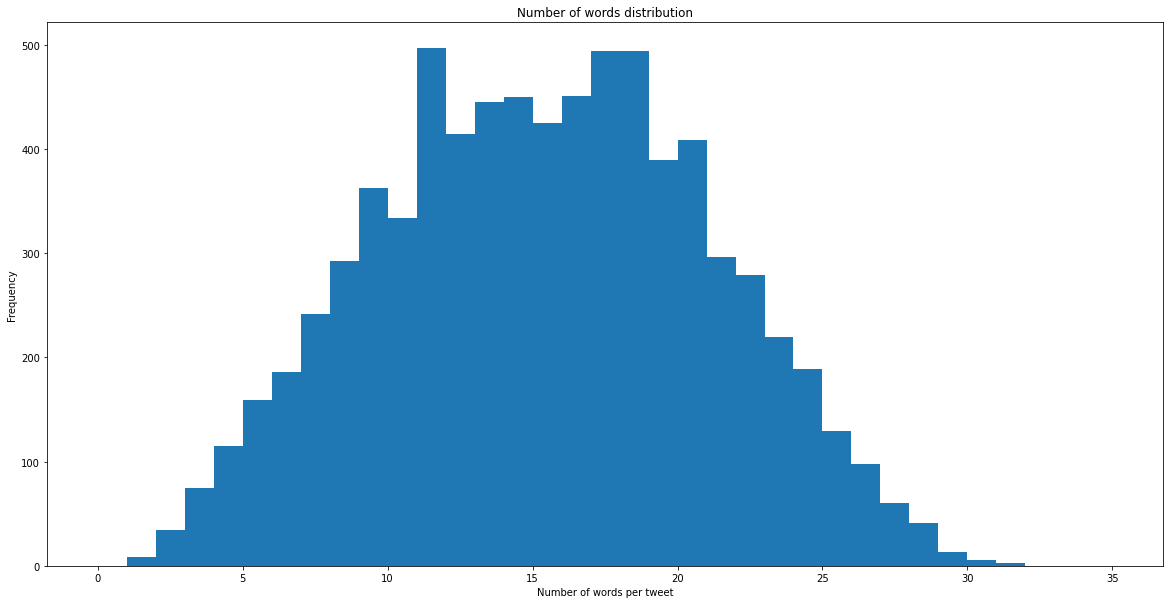

In [72]:
# Number of words per tweet 
plt.figure(figsize=(20,10))
df['text'].str.split().map(lambda x: len(x)).hist(grid=False,bins=range(0,36,1))
plt.xlabel('Number of words per tweet')
plt.ylabel('Frequency')
plt.title('Number of words distribution')

In [ ]:
# In the net few cells, we are going to look at the most common stopwords, and the most common words
# Download spaCy model for American English
!python3 -m spacy download en_core_web_sm

In [56]:
# We will use a spaCy model to tokenize each tweet

import spacy 
import en_core_web_sm
nlp = en_core_web_sm.load()

from collections import defaultdict 

stopword_cnt = defaultdict(int)
for i in range(len(df)):
    doc = nlp(df.iloc[i]['text'].lower()) #tokenize each tweet in lower-case
    for token in doc:
        if token.is_stop:
            stopword_cnt[token.text]+=1 

<BarContainer object of 20 artists>

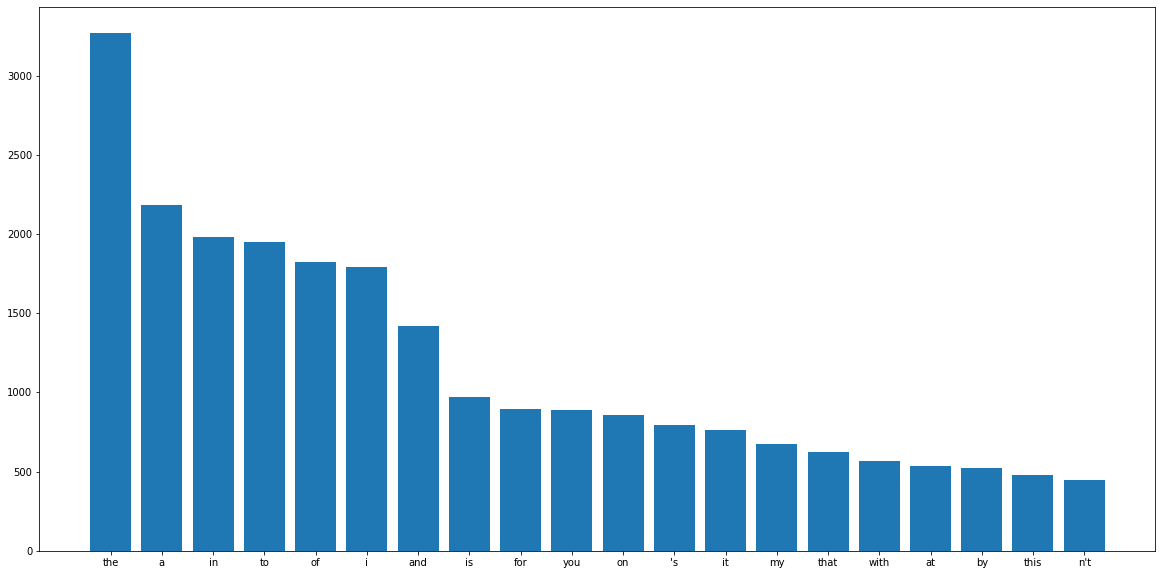

In [73]:
# Sort our stopwords by frequency (descending)
from operator import itemgetter
stopword_cnt_list = sorted(stopword_cnt.items(),key=itemgetter(1),reverse=True)

# Plot a bar chart
plt.figure(figsize=(20,10))
plt.bar([stopword[0] for stopword in stopword_cnt_list[:20]],
        [stopword[1] for stopword in stopword_cnt_list[:20]])

In [5]:
# note that some keywords are phrases, with '%20' as a space
df['keyword'].value_counts() 

fatalities               45
armageddon               42
deluge                   42
harm                     41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [6]:
# note that there are some non-location locations, like 'World Wide!!' and 'a feminist, modernist hag.'
df['location'].value_counts() 

USA                               104
New York                           71
United States                      50
London                             45
Canada                             29
                                 ... 
Lansing, Michigan                   1
San Jose, CA, USA                   1
maryland                            1
District of Gentrification/ DC      1
COMING SOON                         1
Name: location, Length: 3341, dtype: int64

## Preprocessing

In [8]:
# download spaCy model for American English
!python3 -m spacy download en_core_web_sm

You should consider upgrading via the '/Users/weiting/Code/disaster-tweets-classifier/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [9]:
import spacy 
import en_core_web_sm
nlp = en_core_web_sm.load()

## Modifying spaCy's tokenizer

In [10]:
# Let's see what spaCy does with numbers, contractions, #hashtags, @mentions and URLs
s = "2020 can't get any worse #ihate2020 @bestfriend https://t.co"
doc = nlp(s)

# Let's look at the lemmas and is stopword of each token
print(f"Token\t\tLemma\t\tStopword")
print("="*40)
for token in doc:
    print(f"{token}\t\t{token.lemma_}\t\t{token.is_stop}")

Token		Lemma		Stopword
2020		2020		False
ca		can		True
n't		not		True
get		get		True
any		any		True
worse		bad		False
#		#		False
ihate2020		ihate2020		False
@bestfriend		@bestfriend		False
https://t.co		https://t.co		False


In [11]:
# Contractions are split into lemmas
# Numbers are their own features
# @mentions are maintained as a token
# We want to also keep #hashtags as a token, so we will modify the spaCy model's token_match

import re 

# Retrieve the default token-matching regex pattern
re_token_match = spacy.tokenizer._get_regex_pattern(nlp.Defaults.token_match)

# Add #hashtag pattern
re_token_match = f"({re_token_match}|#\w+)"
nlp.tokenizer.token_match = re.compile(re_token_match).match

# Now let's try again
s = "2020 can't get any worse #ihate2020 @bestfriend https://t.co"
doc = nlp(s)

# Let's look at the lemmas and is stopword of each token
print(f"Token\t\tLemma\t\tStopword")
print("="*40)
for token in doc:
    print(f"{token}\t\t{token.lemma_}\t\t{token.is_stop}")

Token		Lemma		Stopword
2020		2020		False
ca		can		True
n't		not		True
get		get		True
any		any		True
worse		bad		False
#ihate2020		#ihate2020		False
@bestfriend		@bestfriend		False
https://t.co		https://t.co		False


## Pre-processing a single tweet

In [12]:
# Features is a set of all lemmas (words) encountered thus far, add hashtags, mentions and URLs to track the number of each respectively
features = set({'#','@','URL'})

# Now let's process an original tweet with our modified spaCy model
s = df.loc[1,'text']
print(f"Original tweet: {s}")

# Modifying the tweet to include mentions, hashtags and a URL
s += ' @mention #hashtag http://t.co/test'

# To lowercase
s = s.lower()

# Creating a doc with spaCy
doc = nlp(s)

# Let's look at the lemmas and is stopword of each token
print(f"Token\t\tLemma\t\tStopword")
print("="*40)

lemmas = []
for token in doc:
    print(f"{token}\t\t{token.lemma_}\t\t{token.is_stop}")
    lemmas.append(token.lemma_)

# Union between lemmas and our features set
features |= set(lemmas)

# Constructing a bag of words for the tweet
freq = {'#':0,'@':0,'URL':0}
for word in lemmas:
    freq[str(word)] = 0
for token in doc: 
    if '#' in str(token): freq['#'] += 1 # Count number of hashtags, regardless of hashtag
    if '@' in str(token): freq['@'] += 1 # Count number of mentions, regardless of mention
    if 'http://' in str(token): freq['URL'] += 1 # Count number of URLs, regardless of URL
    freq[str(token.lemma_)] += 1
print(type(str(token)))
print(f"Bag of words for the tweet: {freq}")

Original tweet: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token		Lemma		Stopword
our		-PRON-		True
deeds		deed		False
are		be		True
the		the		True
reason		reason		False
of		of		True
this		this		True
#earthquake		#earthquake		False
may		may		True
allah		allah		False
forgive		forgive		False
us		-PRON-		True
all		all		True
@mention		@mention		False
#hashtag		#hashtag		False
http://t.co/test		http://t.co/test		False
<class 'str'>
Bag of words for the tweet: {'#': 2, '@': 1, 'URL': 1, '-PRON-': 2, 'deed': 1, 'be': 1, 'the': 1, 'reason': 1, 'of': 1, 'this': 1, '#earthquake': 1, 'may': 1, 'allah': 1, 'forgive': 1, 'all': 1, '@mention': 1, '#hashtag': 1, 'http://t.co/test': 1}


## Preprocessing all data

In [13]:
# Now that we've preprocessed a single tweet, we can create a pre-process function for each tweet
def preprocess(s, nlp, features):
    """
    Given string s, spaCy model nlp, and set features (lemmas encountered),
    pre-process s and return updated features and bag-of-words representation dict freq
    - changes s to lower-case
    - tokenize s using nlp to create a doc
    - update features with lemmas encountered in s
    - create bag-of-words representation in dict type freq, including counts for hashtags, mentions and URLs
    """

    # To lowercase
    s = s.lower()

    # Creating a doc with spaCy
    doc = nlp(s)

    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)

    # Union between lemmas and our features set
    features |= set(lemmas)

    # Constructing a bag of words for the tweet
    freq = {'#':0,'@':0,'URL':0}
    for word in lemmas:
        freq[str(word)] = 0
    for token in doc: 
        if '#' in str(token): freq['#'] += 1 # Count number of hashtags, regardless of hashtag
        if '@' in str(token): freq['@'] += 1 # Count number of mentions, regardless of mention
        if 'http://' in str(token): freq['URL'] += 1 # Count number of URLs, regardless of URL
        freq[str(token.lemma_)] += 1
        
    return features, freq

In [14]:
preprocess_df = df # Duplicate for preprocessing
features = set({'#','@','URL'}) # Using set feature to contain all words (lemmas) seen

In [15]:
bow_array = [] # Array bow_array of bow representations for each tweet; bow_array[i] is the bow representation for tweet id (i+1)
for i in range(len(preprocess_df)):
    features, freq = preprocess(preprocess_df.iloc[i]['text'],nlp,features)
    bow_array.append(freq)
len(bow_array)

7613

In [16]:
# Create dataframe for bag of words representation for each tweet
bow = pd.DataFrame('0', columns=features,index=range(1,len(preprocess_df)+1))
len(bow)

7613

In [17]:
# Update bow[i] with bag-of-words freq of the tweet id (i+1)
for i in range(len(preprocess_df)):
    freq = bow_array[i]
    for f in freq:
        bow.loc[i+1,f]=freq[f]

# Join bag-of-words representation to train dataframe
# Append _data suffix to 'keyword','location','text','target' for features that are not lemma tokens
preprocess_df = preprocess_df.join(bow,lsuffix='_data')

# Saving bag-of-words representation for collaborators
preprocess_df.to_csv("data/train_preprocessed.csv",index=True,index_label='id')

In [18]:
preprocess_df.head(5)

,keyword,location_data,text_data,target_data,drinking,courtney,@blazerfan,#speakingfromexperience,@cortezera,faculty,...,http://t.co/ixw2cutk1c,#oklahoma,http://t.co/s4sicmyrmh,airplane,95,aaarrrgghhh,https://t.co/cvkqigr1az,screams~,#silver,http://t.co/cubc0nq6fd
id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting into training and validation data

In [19]:
from sklearn.model_selection import train_test_split

# stratify=y creates a balanced validation set
y = preprocess_df['target_data']

df_train, df_val = train_test_split(preprocess_df, test_size=0.10, random_state=101, stratify=y)

# Saving csv files for collaborators
df_train.to_csv("data/train_preprocessed_split.csv",index=True)
df_val.to_csv("data/val_preprocessed_split.csv",index=True)

print(df_train.shape, df_val.shape)

(6851, 21330) (762, 21330)


In [20]:
# Checking balance
print(f"""
Ratio of target=1 to target=0 tweets in:\n 
Original data set = {np.sum(preprocess_df['target_data']==1)/np.sum(preprocess_df['target_data']==0)},\n
Training data set = {np.sum(df_train['target_data']==1)/np.sum(df_train['target_data']==0)},\n
Validation data set = {np.sum(df_val['target_data']==1)/np.sum(df_val['target_data']==0)}""")


Ratio of target=1 to target=0 tweets in:
 
Original data set = 0.7533394748963611,

Training data set = 0.7535193242897363,

Validation data set = 0.7517241379310344
